In [ ]:
#!pip uninstall opencv-contrib-python opencv-python

In [ ]:
#!pip install opencv-contrib-python

### Import required libraries

In [2]:
import os
import shutil
import textwrap as tw
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

from scipy import ndimage


# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input

In [3]:
import warnings
warnings.filterwarnings('ignore')

### EDA

In [4]:
data = pd.read_csv("./ISIC_2019_Training_GroundTruth.csv", header = 0)
data.head(20)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB


In [6]:
data.tail()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
data.describe()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
count,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.0
mean,0.178516,0.508270,0.131183,0.034227,0.103588,0.009435,0.009988,0.024792,0.0
std,0.382954,0.499941,0.337607,0.181815,0.304732,0.096677,0.099440,0.155493,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [8]:
data.corr()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
MEL,1.000000,-0.473941,-0.181140,-0.087758,-0.158468,-0.045496,-0.046822,-0.074327,NaN
NV,-0.473941,1.000000,-0.395056,-0.191395,-0.345610,-0.099224,-0.102117,-0.162102,NaN
BCC,-0.181140,-0.395056,1.000000,-0.073151,-0.132092,-0.037923,-0.039029,-0.061955,NaN
AK,-0.087758,-0.191395,-0.073151,1.000000,-0.063995,-0.018373,-0.018909,-0.030016,NaN
BKL,-0.158468,-0.345610,-0.132092,-0.063995,1.000000,-0.033177,-0.034144,-0.054201,NaN
DF,-0.045496,-0.099224,-0.037923,-0.018373,-0.033177,1.000000,-0.009803,-0.015561,NaN
VASC,-0.046822,-0.102117,-0.039029,-0.018909,-0.034144,-0.009803,1.000000,-0.016015,NaN
SCC,-0.074327,-0.162102,-0.061955,-0.030016,-0.054201,-0.015561,-0.016015,1.000000,NaN
UNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC' : 'Squamous cell carcinoma'
} 

In [10]:
# print all columns
pd.set_option('display.max_columns', None)

# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)### Step 1: Load and preprocess the image within the CNN architecture

### Step 1: Load and preprocess the image within the CNN architecture

In [11]:
def load_data(path: str):
    dir = Path(path)
    
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)

df = load_data('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [12]:
# total categires 
len(os.listdir('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'))

9

In [13]:
os.listdir('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [14]:
list_diseases = os.listdir('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [15]:
results2 = []
for disease in list_diseases:
    dies_name_count = {}
    count_disease = len(os.listdir(f'./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'))
    dies_name_count['disease'] = disease
    dies_name_count['count_images'] = count_disease
    results2.append(dies_name_count)

In [16]:
results = pd.DataFrame(results2)
results

,disease,count_images
0,actinic keratosis,9
1,basal cell carcinoma,9
2,dermatofibroma,9
3,melanoma,9
4,nevus,9
5,pigmented benign keratosis,9
6,seborrheic keratosis,9
7,squamous cell carcinoma,9
8,vascular lesion,9


In [17]:
df.head(15)

,FilePaths,Labels
0,input\skin-cancer9-classesisic\Skin cancer ISI...,squamous cell carcinoma
1,input\skin-cancer9-classesisic\Skin cancer ISI...,basal cell carcinoma
2,input\skin-cancer9-classesisic\Skin cancer ISI...,pigmented benign keratosis
3,input\skin-cancer9-classesisic\Skin cancer ISI...,pigmented benign keratosis
4,input\skin-cancer9-classesisic\Skin cancer ISI...,seborrheic keratosis
5,input\skin-cancer9-classesisic\Skin cancer ISI...,melanoma
6,input\skin-cancer9-classesisic\Skin cancer ISI...,basal cell carcinoma
7,input\skin-cancer9-classesisic\Skin cancer ISI...,actinic keratosis
8,input\skin-cancer9-classesisic\Skin cancer ISI...,nevus
9,input\skin-cancer9-classesisic\Skin cancer ISI...,melanoma


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FilePaths  2239 non-null   object
 1   Labels     2239 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB


[Text(0, 0, 'seborrheic keratosis'),
 Text(1, 0, 'dermatofibroma'),
 Text(2, 0, 'actinic keratosis'),
 Text(3, 0, 'vascular lesion'),
 Text(4, 0, 'squamous cell carcinoma'),
 Text(5, 0, 'nevus'),
 Text(6, 0, 'basal cell carcinoma'),
 Text(7, 0, 'melanoma'),
 Text(8, 0, 'pigmented benign keratosis')]

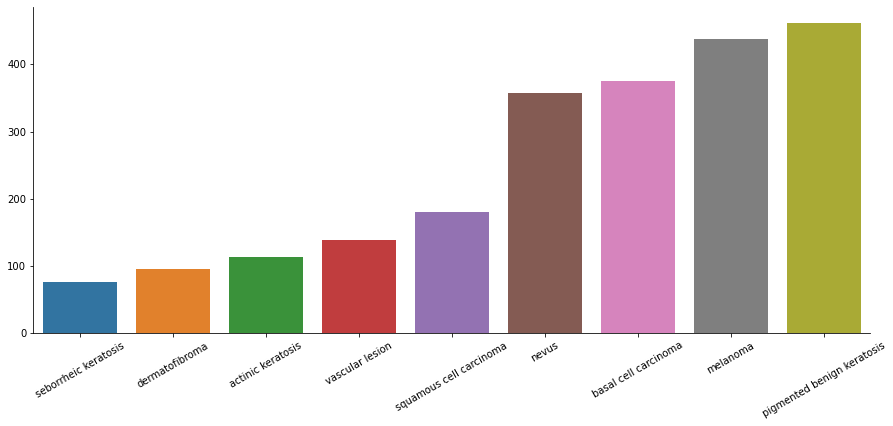

In [19]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(labels_count.index,labels_count.values)
sns.despine()
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

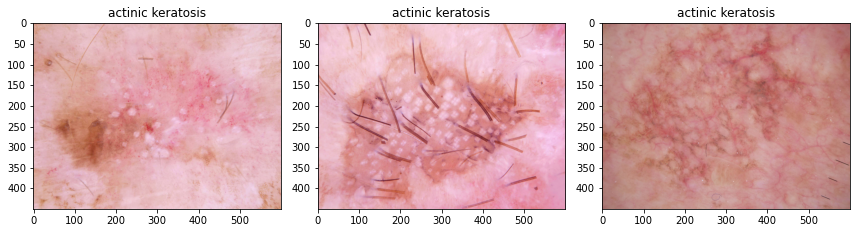

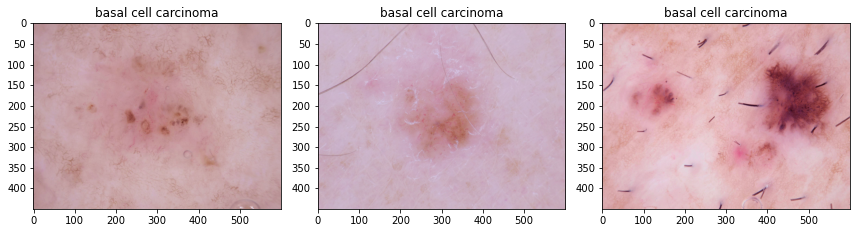

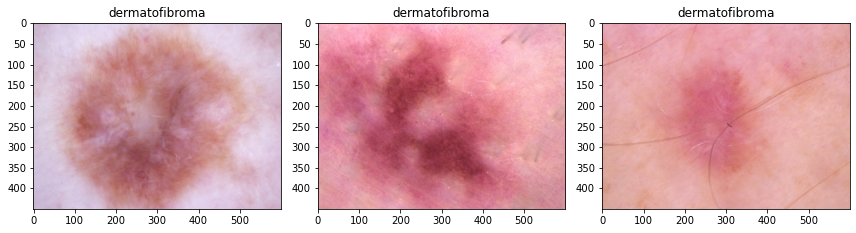

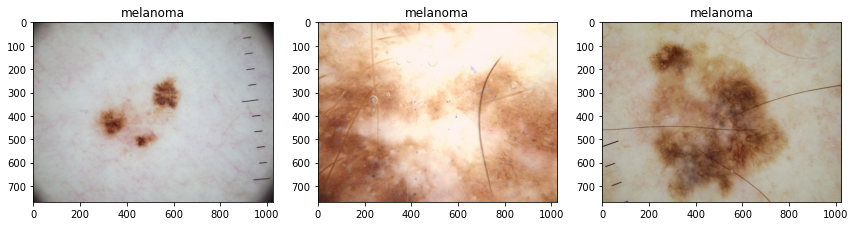

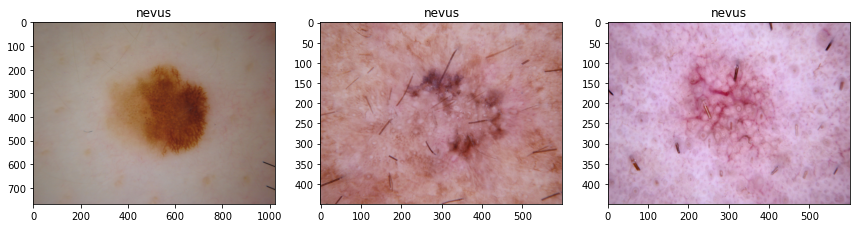

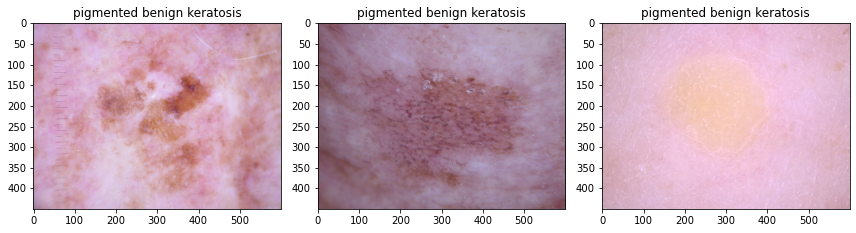

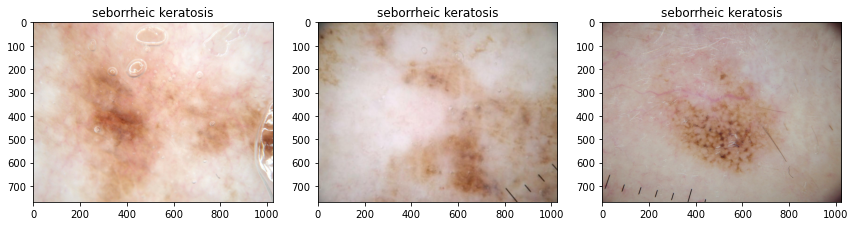

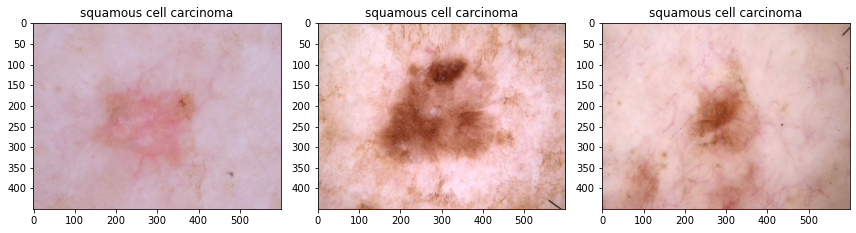

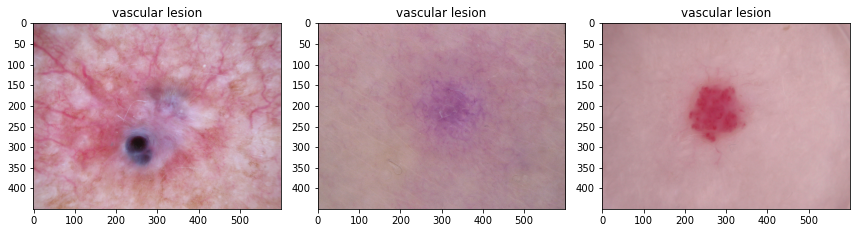

In [20]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

In [21]:
from sklearn.model_selection import train_test_split

# stratified train and val (25%) datasets
X_train, X_val = train_test_split(df, test_size=0.25, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1679, 2)
Val Data:  (560, 2)


In [22]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)
# count of epchos
EPOCHS = 10

# image preprocessing
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1679 validated image filenames belonging to 9 classes.
Found 560 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


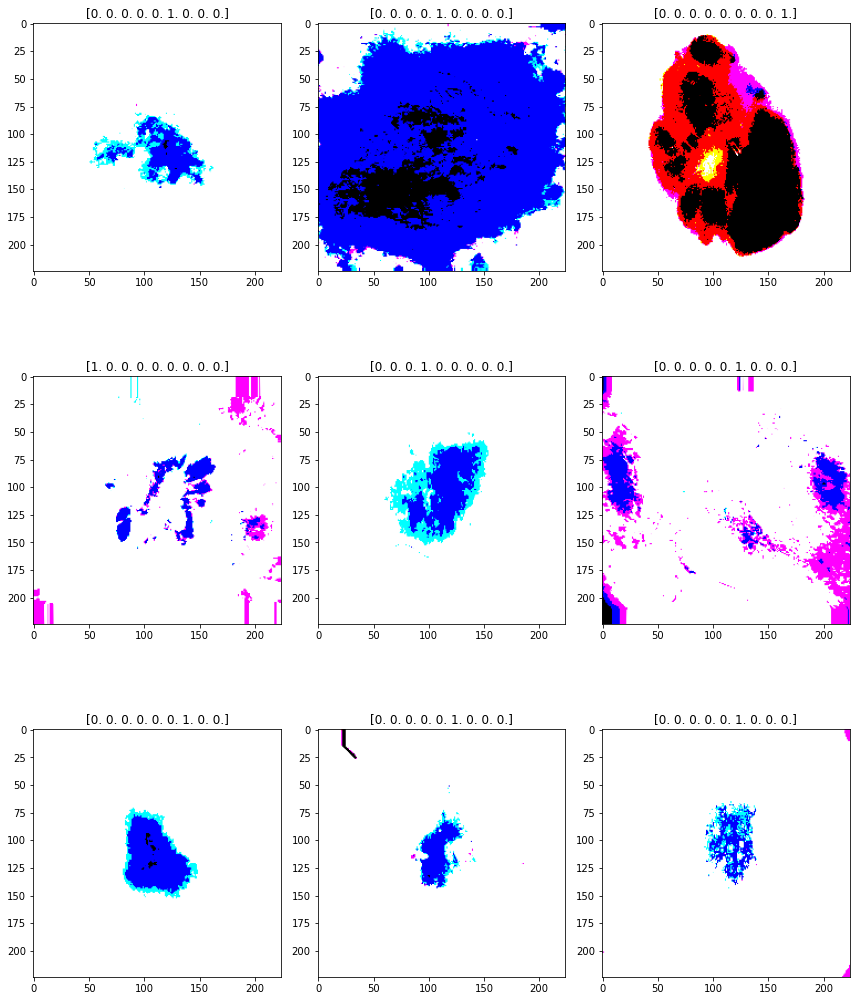

In [23]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,15))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [24]:
#training data
training_dir="./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

#increases amount of data by making different forms of image
training_generator = ImageDataGenerator(rescale=1/255,
                                        featurewise_center = True,
                                        samplewise_center=True, 
                                        featurewise_std_normalization=False,
                                        samplewise_std_normalization=True,
                                        zca_whitening=False,
                                        rotation_range=30, 
                                        zoom_range=0.2, 
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True, 
                                        vertical_flip=True)

#creates accessible training data
train_generator=training_generator.flow_from_directory(training_dir,target_size=(224,224), 
                                                       batch_size=4,class_mode='binary')

Found 2239 images belonging to 9 classes.


In [25]:
#validation data
validation_dir="./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

#increases amount of data by making different forms of image
validation_generator=ImageDataGenerator(rescale=1/255)
val_generator=validation_generator.flow_from_directory(validation_dir,target_size=(224,224), batch_size=4, class_mode='binary')

Found 118 images belonging to 9 classes.


In [26]:
#testing data
testing_dir="./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

#increases amount of data by making different forms of image
testing_generator = ImageDataGenerator(rescale=1/255,
                                        featurewise_center = False,
                                        samplewise_center=False, 
                                        featurewise_std_normalization=False,
                                        samplewise_std_normalization=False,
                                        zca_whitening=False,
                                        rotation_range=30, 
                                        zoom_range=0.2, 
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=False, 
                                        vertical_flip=False)

#creates accessible testing data
test_generator=training_generator.flow_from_directory(testing_dir,target_size=(224,224), 
                                                       batch_size=4,class_mode='binary')

Found 118 images belonging to 9 classes.


In [27]:
#model sequelling
model = Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape = (224,224,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

In [28]:
#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [29]:
# stop training when accuracy has stopped improving 
cb = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=3)
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS, callbacks=cb)

# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/10
53/53 [==============================] - 359s 7s/step - loss: 27.3876 - acc: 0.8592 - val_loss: 0.4096 - val_acc: 0.8889
Epoch 2/10
53/53 [==============================] - 303s 6s/step - loss: 0.3610 - acc: 0.8889 - val_loss: 0.4026 - val_acc: 0.8889
Epoch 3/10
53/53 [==============================] - 316s 6s/step - loss: 0.3586 - acc: 0.8889 - val_loss: 0.3965 - val_acc: 0.8889
Epoch 4/10
53/53 [==============================] - 316s 6s/step - loss: 0.3587 - acc: 0.8889 - val_loss: 0.3881 - val_acc: 0.8889
Epoch 5/10
53/53 [==============================] - 288s 5s/step - loss: 0.3579 - acc: 0.8889 - val_loss: 0.3892 - val_acc: 0.8889
Epoch 6/10
53/53 [==============================] - 286s 5s/step - loss: 0.3577 - acc: 0.8889 - val_loss: 0.3863 - val_acc: 0.8889
Epoch 7/10
53/53 [==============================] - 283s 5s/step - loss: 0.3580 - acc: 0.8889 - val_loss: 0.3727 - val_acc: 0.8889
Epoch 8/10
53/53 [==============================] - 310s 6s/step - loss: 0.3569 - 

In [52]:
#Save weights and params
#model.save()

<Figure size 432x288 with 0 Axes>

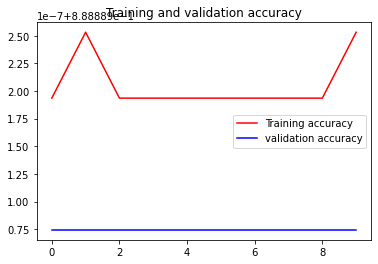

<Figure size 432x288 with 0 Axes>

In [53]:
acc = hst.history['acc']
val_acc = hst.history['val_acc']
loss = hst.history['loss']
val_loss = hst.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc= 0)
plt.figure()


In [54]:
X_test = load_data('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

X_test.head(15)

,FilePaths,Labels
0,input\skin-cancer9-classesisic\Skin cancer ISI...,pigmented benign keratosis
1,input\skin-cancer9-classesisic\Skin cancer ISI...,actinic keratosis
2,input\skin-cancer9-classesisic\Skin cancer ISI...,melanoma
3,input\skin-cancer9-classesisic\Skin cancer ISI...,basal cell carcinoma
4,input\skin-cancer9-classesisic\Skin cancer ISI...,nevus
5,input\skin-cancer9-classesisic\Skin cancer ISI...,basal cell carcinoma
6,input\skin-cancer9-classesisic\Skin cancer ISI...,dermatofibroma
7,input\skin-cancer9-classesisic\Skin cancer ISI...,dermatofibroma
8,input\skin-cancer9-classesisic\Skin cancer ISI...,nevus
9,input\skin-cancer9-classesisic\Skin cancer ISI...,dermatofibroma


In [55]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


vascular lesion                3
seborrheic keratosis           3
actinic keratosis             16
squamous cell carcinoma       16
basal cell carcinoma          16
nevus                         16
melanoma                      16
pigmented benign keratosis    16
dermatofibroma                16
Name: Labels, dtype: int64

#### Image Preprocessing

In [56]:
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


In [57]:
res = model.evaluate(X_test)

4/4 [==============================] - 42s 10s/step - loss: 0.3855 - acc: 0.8889


#### Accuracy and loss

In [58]:
print(f'Train Accuracy: {hst.history["acc"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_acc"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')

print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 88.89
Val Accuracy: 88.89
Test Accuracy: 88.89
Train Loss: 35.44
Val Loss: 38.74
Test Loss: 38.55


#### Predicted Labels and Rounded Labels

In [59]:
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)

y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

4/4 [==============================] - 40s 10s/step
Y_pred (118, 1)
y_pred 118


#### True Labels and Label Classes

In [60]:
y_true = X_test.classes
print("y_pred", len(y_pred))

class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9


[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

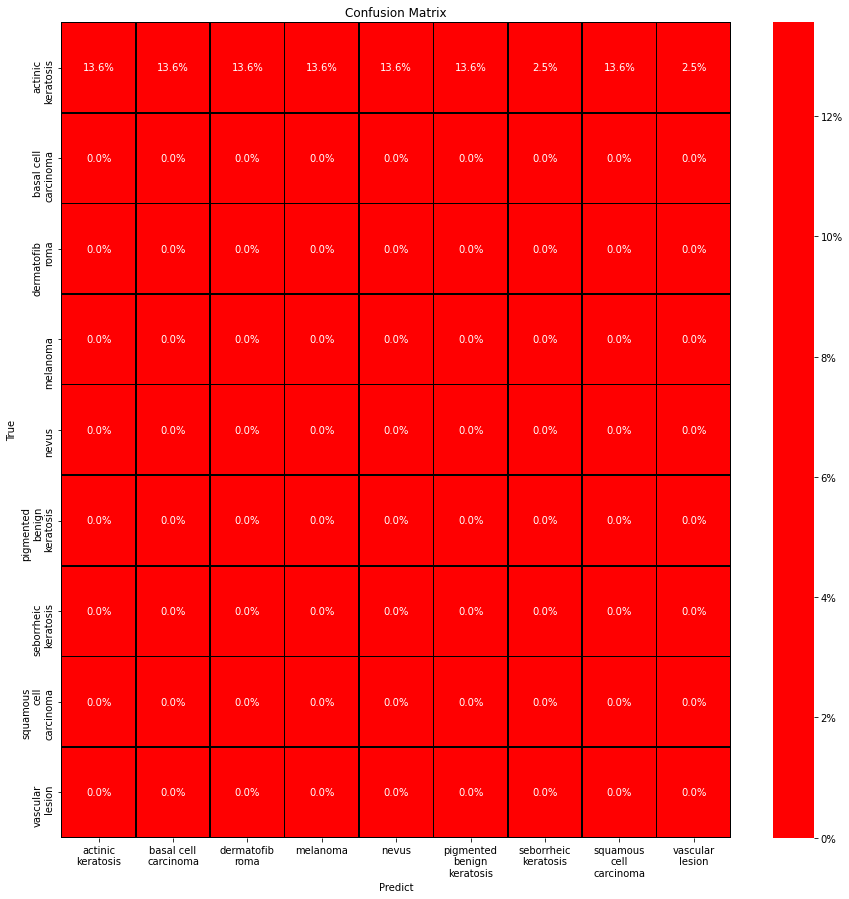

In [61]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(15,15))

# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0001', '#09AA11'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, 
               linecolor='Black',
               ax=ax)

# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])

In [62]:
def load_data(path: str):
    dir = Path(path)
    
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)

df = load_data('./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

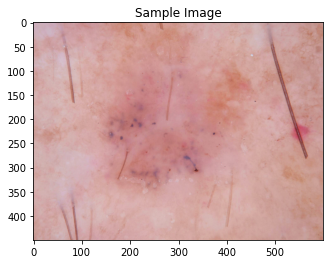

In [63]:
# Read Sample Image
image_path = "./input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/ISIC_0024331.jpg"
image = plt.imread(image_path)

plt.title("Sample Image")
plt.imshow(image)

In [64]:
preprocessed_image = model.output
preprocessed_image = model.predict(np.expand_dims(image, axis=0))[0]

ValueError: in user code:

    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Sachit Girish\Anaconda_IDE\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 450, 600, 3)


### Step 1: Preprocessing

#### Step 1.1: Apply Hough's transform to remove hair

In [65]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [66]:
# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

In [67]:
# Apply Hough's transform to detect lines representing hair
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)

In [68]:
# Create a mask image to draw the detected lines
mask = np.zeros_like(image)

In [69]:
# Draw the detected lines on the mask image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness=2)

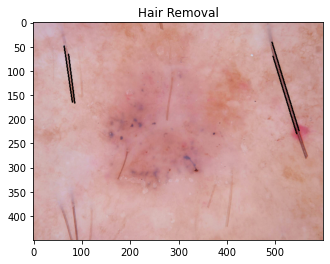

In [70]:
# Apply bitwise AND operation to remove hair from the original image
hair_removed = cv2.bitwise_and(image, cv2.bitwise_not(mask))

plt.title("Hair Removal")
plt.imshow(hair_removed)

#### Step 1.2: Apply MATLAB filters to remove shade and glare

In [71]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [72]:
# Apply shading correction filter (e.g., morphological opening)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
shading_corrected = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

In [73]:
# Apply glare removal filter (e.g., guided filter)
radius = 10
epsilon = 0.1
glare_removed = cv2.ximgproc.guidedFilter(shading_corrected, gray, radius, epsilon)

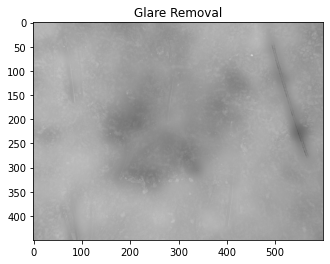

In [74]:
# Convert the image back to color if needed
if len(image.shape) == 3:
    glare_removed = cv2.cvtColor(glare_removed, cv2.COLOR_GRAY2BGR)

plt.title("Glare Removal")
plt.imshow(glare_removed)

#### Step 1.3: Perform contrast enhancement

In [75]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [76]:
# Apply contrast enhancement algorithm (e.g., histogram equalization)
enhanced = cv2.equalizeHist(gray)

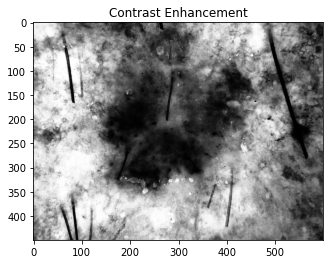

In [77]:
# Convert the enhanced grayscale image back to the original color space if needed
if len(image.shape) == 3:
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    
plt.title("Contrast Enhancement")
plt.imshow(enhanced)

### Step 2: Perform segmentation using Otsu's thresholding

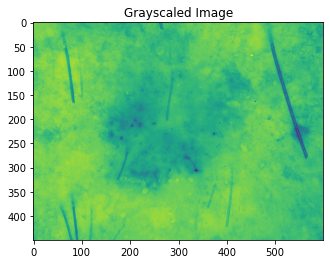

In [78]:
# Convert the image to grayscale
gray_image = rgb2gray(image)

plt.title("Grayscaled Image")
plt.imshow(gray_image)

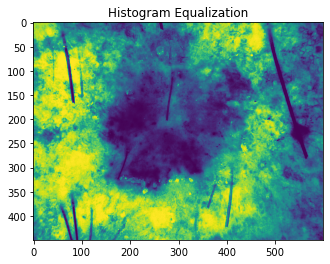

In [79]:
# Apply histogram equalization
equalized_image = cv2.equalizeHist((gray_image * 255).astype(np.uint8))

plt.title("Histogram Equalization")
plt.imshow(equalized_image)

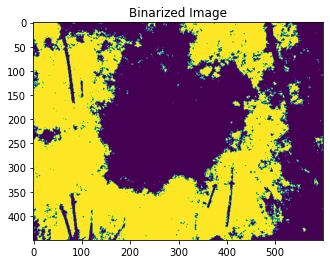

In [80]:
# Perform Otsu's thresholding
threshold_value = threshold_otsu(equalized_image)
binary_image = (equalized_image > threshold_value).astype(np.uint8)

plt.title("Binarized Image")
plt.imshow(binary_image)

### Step 3: Extract features

In [81]:
# Compute the area of the segmented region
area = np.sum(binary_image)

# Compute the mean, variance, and standard deviation of the segmented region
masked_image = gray_image * binary_image
mean = np.mean(masked_image)
variance = np.var(masked_image)
std_dev = np.std(masked_image)

features = [mean, variance, std_dev, area]

print(f"mean: {mean}\nvariance: {variance}\nstandard deviation: {std_dev}\narea: {area}")

mean: 0.3480792389876544
variance: 0.12334716974478208
standard deviation: 0.3512081572867892
area: 133910


### Step 4: Process image to get mean value of red, blue, and green pixels

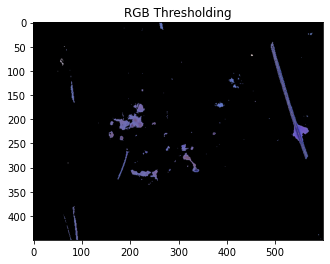

In [82]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the pixel data of the image
pixels = image[0:image.shape[0], 0:image.shape[1], 0:4]

# Initialize variables for accumulating the total sum of red, green, and blue values
total_red = 0
total_green = 0
total_blue = 0

# Iterate over each pixel in the image
for y in range(image.shape[1]):
    for x in range(image.shape[0]):
        # Get the RGB values of the current pixel
        r, g, b = pixels[x, y]

        # Accumulate the RGB values
        total_red += r
        total_green += g
        total_blue += b

# Calculate the mean values
num_pixels = image.shape[0] * image.shape[1]
mean_red = total_red / num_pixels
mean_green = total_green / num_pixels
mean_blue = total_blue / num_pixels

# Calculate the mean color distance threshold
threshold = 60

# Iterate over each pixel again to check and discard portions based on mean color distance
for y in range(image.shape[1]):
  for x in range(image.shape[0]):
      # Get the RGB values of the current pixel
      r, g, b = pixels[x, y]

      # Calculate the Euclidean distance between the pixel's color and the mean color
      distance = ((r - mean_red) ** 2 + (g - mean_green) ** 2 + (b - mean_blue) ** 2) ** 0.5

      # Discard the pixel if the mean color distance is less than the threshold
      if distance < threshold:
          pixels[x, y] = (0, 0, 0)  # Set the pixel to black

plt.title("RGB Thresholding")
plt.imshow(image)

### Step 5: Perform border extraction to segment the image into lesion and background skin

In [83]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [84]:
# Apply edge detection (e.g., Canny edge detector)
edges = cv2.Canny(gray, 100, 200)

In [85]:
# Apply threshold to obtain a binary image
_, thresholded = cv2.threshold(edges, 128, 255, cv2.THRESH_BINARY)

In [86]:
# Perform morphological operations (e.g., dilation) if needed
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(thresholded, kernel, iterations=1)

In [87]:
# Create a segmented image by masking the original image with the extracted borders
segmented = cv2.bitwise_and(image, image, mask=dilated)

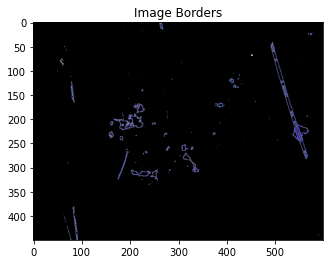

In [88]:
plt.title("Image Borders")
plt.imshow(segmented)

### Step 6: Classify the image using Support Vector Machines (SVM)

In [89]:
train,test = train_test_split(data, test_size = 100)
print(train.shape)
print(test.shape)

prediction_var = ['MEL', 'NV', 'BCC', 'AK', 'BKL','DF','VASC','SCC']

train_X = train[prediction_var]
train_Y = train.MEL
test_X = test[prediction_var]
test_Y = test.MEL

model = svm.SVC()
model.fit(train_X, train_Y)

prediction = model.predict(test_X)

print(prediction)

(25231, 10)
(100, 10)
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0.]


In [90]:
from sklearn import metrics
metrics.accuracy_score(prediction, test_Y)

1.0